# Analyze users by inspecting retweet counts

In [1]:
import os
import pandas as pd
import re
from IPython.display import clear_output

In [2]:
DATADIR = "/home/erikt/projects/puregome/data/retweets/"
RIGHT = "geertwilderspvv thierrybaudet PvanHouwelingen fvdemocratie hansvantelling rblommestijn Kees71234".split(" ")
DUTCHPRESS = "telegraaf NOS RTLnieuws NUnl ADnl nrc volkskrant trouw parool AT5 NPORadio1 Nieuwsuur op1npo EenVandaag NPORadio1".split(" ")
FLEMISHPRESS = "HLN_BE demorgen destandaard vrtnws Nieuwsblad_be deafspraaktv VTMNIEUWS".split(" ")

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

## 1. Read the retweet data

In [4]:
file_names = os.listdir(DATADIR)
df_total = pd.DataFrame([])
for file_name in sorted(file_names):
    if re.search(r"^2", file_name):
        df = pd.read_csv(DATADIR+file_name, sep=",", compression="gzip").loc[:, ["user", "retweeted_user"]]
        df_total = pd.concat([df_total, df])
        squeal(file_name)

20211231-23.out.gz


In [5]:
len(df_total)

7981429

## 2. Create a lists of retweeted users per retweeter

In [6]:
groups = df_total.groupby(["user", "retweeted_user"]).groups

## 3. Check how often each retweeter retweets users of the three main groups 

In [7]:
profiles = {}


def add(user, group, count):
    if not user in profiles: 
        profiles[user] = { RIGHT[0]: 0, DUTCHPRESS[0]: 0, FLEMISHPRESS[0]: 0}
    profiles[user][group[0]] += count

        
counter = 0
for key in groups.keys():
    counter += 1
    if counter % 10000 == 0: 
        squeal(str(counter)+"/"+str(len(groups)))
    retweetedUser = key[1]
    retweeter = key[0]
    if retweetedUser in RIGHT: 
        add(retweeter, RIGHT, len(groups[key]))
    elif retweetedUser in DUTCHPRESS: 
        add(retweeter, DUTCHPRESS, len(groups[key]))
    elif retweetedUser in FLEMISHPRESS: 
        add(retweeter, FLEMISHPRESS, len(groups[key]))
squeal(str(counter)+"/"+str(len(groups)))

4457571/4457571


In [ ]:
{ key: profiles[key] for key in profiles if profiles[key]["geertwilderspvv"] >= 800 }

## 4. Get users with retweets of only one group

In [8]:
MIN = 5
usersPerGroup = {RIGHT[0]:[],DUTCHPRESS[0]:[],FLEMISHPRESS[0]:[]}
for user in profiles:
    if profiles[user][RIGHT[0]] > MIN and profiles[user][DUTCHPRESS[0]] == 0 and profiles[user][FLEMISHPRESS[0]] == 0:
        usersPerGroup[RIGHT[0]].append(user)
    if profiles[user][RIGHT[0]] == 0 and profiles[user][DUTCHPRESS[0]] > MIN and profiles[user][FLEMISHPRESS[0]] == 0:
        usersPerGroup[DUTCHPRESS[0]].append(user)
    if profiles[user][RIGHT[0]] == 0 and profiles[user][DUTCHPRESS[0]] == 0 and profiles[user][FLEMISHPRESS[0]] > MIN:
        usersPerGroup[FLEMISHPRESS[0]].append(user)

In [9]:
len(usersPerGroup[RIGHT[0]]),len(usersPerGroup[DUTCHPRESS[0]]),len(usersPerGroup[FLEMISHPRESS[0]])

(4765, 987, 111)

## 5. Inspect favorite users per group

In [ ]:
df_selected = df_total.loc[df_total["user"].isin(usersPerGroup[RIGHT[0]])]
df_selected["retweeted_user"].value_counts()[:10]

In [ ]:
df_selected = df_total.loc[df_total["user"].isin(usersPerGroup[DUTCHPRESS[0]])]
df_selected["retweeted_user"].value_counts()[:20]

In [ ]:
df_selected = df_total.loc[df_total["user"].isin(usersPerGroup[FLEMISHPRESS[0]])]
df_selected["retweeted_user"].value_counts()[:20]

## 6. Principal component analysis

Source: https://nickmccullum.com/python-machine-learning/principal-component-analysis-python/

In [10]:
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [11]:
COLORS = { "RIGHT": "y", "DUTCHPRESS": "g", "FLEMISHPRESS": "b", "OTHER": "k" }
INVERTED_COLORS = { COLORS[x]: x for x in COLORS }

In [12]:
data_scaler = StandardScaler()

In [13]:
data_dict = {}
retweeted_counts = {}
user_colors = []

for key_pair in groups:
    user, retweeted_user = key_pair
    if retweeted_user not in retweeted_counts:
        retweeted_counts[retweeted_user] = 0
    retweeted_counts[retweeted_user] += len(groups[key_pair])


for key_pair in groups:
    user, retweeted_user = key_pair
    if retweeted_counts[retweeted_user] > 10000:
        if user not in data_dict:
            data_dict[user] = {}
        data_dict[user][retweeted_user] = len(groups[key_pair])

        
for user in data_dict:
    for retweeted_user in data_dict[user]:
        data_dict[user][retweeted_user] = math.log10(data_dict[user][retweeted_user])
        
        
for user in data_dict:
    if user in usersPerGroup[RIGHT[0]]:
        user_colors.append(COLORS["RIGHT"])
    elif user in usersPerGroup[DUTCHPRESS[0]]:
        user_colors.append(COLORS["DUTCHPRESS"])
    elif user in usersPerGroup[FLEMISHPRESS[0]]:
        user_colors.append(COLORS["FLEMISHPRESS"])
    else:
        user_colors.append(COLORS["OTHER"])

In [14]:
data_df = pd.DataFrame([data_dict[user] for user in data_dict]).fillna(0)

In [15]:
len(data_df), len(data_df.loc[0])

(65204, 82)

In [16]:
data_scaler.fit(data_df)

StandardScaler()

In [17]:
scaled_data_frame = data_scaler.transform(data_df)

In [18]:
pca = PCA(n_components = 4)

In [19]:
pca.fit(scaled_data_frame)

PCA(n_components=4)

In [20]:
data_pca = pca.transform(scaled_data_frame)

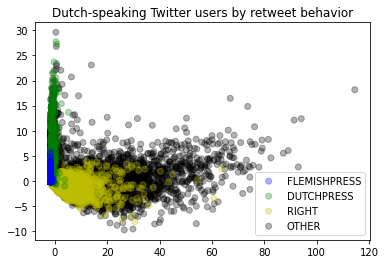

In [22]:
fig, ax = plt.subplots()
for color in ["k", "y", "g", "b"]:
    x = [data_pca[i][0] for i in range(0, len(user_colors)) if user_colors[i] == color]
    y = [data_pca[i][3] for i in range(0, len(user_colors)) if user_colors[i] == color]
    c = [user_colors[i] for i in range(0, len(user_colors)) if user_colors[i] == color]
    ax.scatter(x, y, c=c, alpha=0.3, label=INVERTED_COLORS[color])
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
ax.legend(handles, labels)
plt.title("Dutch-speaking Twitter users by retweet behavior")
plt.show()

In [ ]:
users = list(data_dict.keys())
for i in range(0, len(users)):
    if data_pca[i][0] > 80:
        print(f"{int(data_pca[i][0]):3} {int(data_pca[i][3]):2} {user_colors[i]} {users[i]}")

In [ ]:
for i in range(0, len(users)):
    if data_pca[i][3] > 23:
        print(f"{int(data_pca[i][0]):2} {int(data_pca[i][3]):2} {user_colors[i]} {users[i]}")

## Check for other interesting retweeted users per group (optional)

In [ ]:
retweetedUsers = []
counter = 0
for user in usersPerGroup[RIGHT[0]]:
    counter += 1
    squeal(str(counter)+"/"+str(len(usersPerGroup[RIGHT[0]])))
    retweetedUsers.extend([ x[1] for x in groups if x[0] == user ])
retweetedUsersDict  = pd.DataFrame(retweetedUsers).groupby(0).groups

In [ ]:
list({key:len(retweetedUsersDict[key]) for key in sorted(retweetedUsersDict.keys(),
                                                         key=lambda k:len(retweetedUsersDict[k]),reverse=True)}.items())[0:20]

In [ ]:
list({key:len(retweetedUsersDict[key]) for key in sorted(retweetedUsersDict.keys(),
                                                         key=lambda k:len(retweetedUsersDict[k]),reverse=True)}.items())[0:20]

In [ ]:
list({key:len(retweetedUsersDict[key]) for key in sorted(retweetedUsersDict.keys(),
                                                         key=lambda k:len(retweetedUsersDict[k]),reverse=True)}.items())[0:20]

## Get tweet texts of selected users (optional)

In [ ]:
import os
import re

In [ ]:
DATADIRTEXT = "/home/erikt/projects/puregome/data/text/"
FILEPATTERN = "2020060[1-7]"
USER = "user"
TEXT = "text"

In [ ]:
selectedUsers = usersPerGroup[RIGHT[0]]+usersPerGroup[DUTCHPRESS[0]]+usersPerGroup[FLEMISHPRESS[0]]
files = sorted(os.listdir(DATADIRTEXT))
tweetTexts = {}
for inFileName in files:
    if re.search(FILEPATTERN,inFileName):
        squeal(inFileName)
        df = pd.read_csv(DATADIRTEXT+inFileName)
        for i in range(0,len(df)):
            user = df.iloc[i][USER]
            if df.iloc[i][USER] in selectedUsers:
                if not user in tweetTexts: tweetTexts[user] = df.iloc[i][TEXT]
                else: tweetTexts[user] += " "+df.iloc[i][TEXT]
tweetTexts

## Tokenize tweet texts (optional)

In [ ]:
from nltk.tokenize import TweetTokenizer

In [ ]:
def removeKeywords(text):
    for keyword in RIGHT+DUTCHPRESS+FLEMISHPRESS:
        text = re.sub(r"\b"+keyword.lower()+r"\b"," ",text)
    return(text)

In [ ]:
tokenizedTweetTexts = {}
tokenizer = TweetTokenizer()
for user in tweetTexts.keys():
    tokenizedTweetTexts[user] = " ".join(tokenizer.tokenize(re.sub(r"\\n"," ",removeKeywords(tweetTexts[user].lower()))))

## Save tweet texts (optional)

In [ ]:
OUTFILENAME = "groups-train.txt"
LABELPREFIX = "__label__"
RIGHTTEXT = "RIGHT"
DUTCHPRESSTEXT = "DUTCHPRESS"
FLEMISHPRESSTEXT = "FLEMISHPRESS"

outFile = open(OUTFILENAME,"w")
for user in tokenizedTweetTexts:
    if user in usersPerGroup[RIGHT[0]]: label = RIGHTTEXT
    elif user in usersPerGroup[DUTCHPRESS[0]]: label = DUTCHPRESSTEXT
    elif user in usersPerGroup[FLEMISHPRESS[0]]: label = FLEMISHPRESSTEXT
    else: sys.exit("cannot happen!")
    print(LABELPREFIX+label,tokenizedTweetTexts[user],file=outFile)
outFile.close()

## Evaluate fasttext on data (optional)

In [ ]:
import fasttext
import os
import random

In [ ]:
TRAINFILE = "groups-train.txt"
LARGEINT = 99999999

In [ ]:
fasttextData = []
inFile = open(TRAINFILE,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()

In [ ]:
DIM = 300
EPOCH = 100
LR = 0.1
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))

predictionCounts = []
predictionLabels = []
for fold in range(0,N):
    squeal("starting fold "+str(fold))
    testStart = round(fold*len(fasttextData)/N)
    testEnd = round((fold+1)*len(fasttextData)/N)
    trainFile = open(TRAIN,"w")
    testFile = open(TEST,"w")
    testData = []
    for i in range(0,len(fasttextData)):
        if i < testStart or i >= testEnd: print(fasttextData[i],file=trainFile)
        else: 
            print(fasttextData[i],file=testFile)
            testData.append(fasttextData[i])
    testFile.close()
    trainFile.close()
    model = fasttext.train_supervised(TRAIN,dim=DIM,epoch=EPOCH,lr=LR) # ,pretrainedVectors=PRETRAINEDDIR+WIKIFILENAME)
    predictionCounts.append([*model.test(TEST)])
    predictionLabels.append(model.predict(testData))
    os.unlink(TRAIN)
    os.unlink(TEST)
clear_output(wait=True)
print("finished")

In [ ]:
caseTotal = 0
pTotal = 0
rTotal = 0
for i in range(0,len(predictionCounts)):
    caseTotal += predictionCounts[i][0]
    pTotal += predictionCounts[i][0]*predictionCounts[i][1]
    rTotal += predictionCounts[i][0]*predictionCounts[i][2]
print("cases: {0}; precision: {1}; recall: {2}".format(caseTotal,round(pTotal/caseTotal,3),round(rTotal/caseTotal,3)))

Scores: epoch=10 P=52; epoch=20 P=86; epoch=30 P=89; epoch=50 P=91; epoch=100 P=94.7; epoch=200 P=94.8; epoch=130 P=95.1; epoch=150 P=95.0

In [ ]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1
labelCountsGold

In [ ]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabels)):
    for label in predictionLabels[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1
labelCountsPredicted

In [ ]:
for i in range(0,len(fasttextData)):
    labelGold = fasttextData[i].split()[0]
    labelPredicted = predictionLabels[i][0]
    print(labelGold,labelPredicted)
    break

## Apply fasttext to other data

In [ ]:
import csv
import fasttext
import os
import re
import pandas as pd
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [ ]:
TRAINFILE = "groups-train.txt"
DIM = 300
EPOCH = 100
LR = 0.1
RIGHTTEXT = "RIGHT"
DUTCHPRESSTEXT = "DUTCHPRESS"
FLEMISHPRESSTEXT = "FLEMISHPRESS"

In [ ]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [ ]:
model = fasttext.train_supervised(TRAINFILE,dim=DIM,epoch=EPOCH,lr=LR)

In [ ]:
TEXT = "text"
USER = "user"
TESTFILEPATTERN = "2020061[6-9]|2020062[0-2]"
DATADIRTEXT = "/home/erikt/projects/puregome/data/text/"

files = sorted(os.listdir(DATADIRTEXT))
tokenizer = TweetTokenizer()
userTexts = {}
for inFileName in files:
    if re.search(TESTFILEPATTERN,inFileName):
        squeal(inFileName)
        df = pd.read_csv(DATADIRTEXT+inFileName)
        for i in range(0,len(df)): 
            user = df.iloc[i][USER]
            text = df.iloc[i][TEXT]
            if user in userTexts: userTexts[user] += " "+text
            else: userTexts[user] = text
tokenizedTexts = {}
for user in userTexts:
    tokenizedTexts[user] = " ".join(tokenizer.tokenize(re.sub(r"\\n"," ",userTexts[user].lower())))
predictedLabels = model.predict([tokenizedTexts[user] for user in tokenizedTexts.keys()])

In [ ]:
LABEL = "label"
CONFIDENCE = "confidence"

predictedLabelsDict = {}
counter = 0
for user in tokenizedTexts:
    predictedLabelsDict[user] = { LABEL:predictedLabels[0][counter][0], CONFIDENCE:predictedLabels[1][counter][0] }
    counter += 1

In [ ]:
MAXCOUNTER = 1

counter = 0
for user in sorted(tokenizedTexts.keys(),key=lambda k:len(tokenizedTexts[k]),reverse=True):
    print(predictedLabelsDict[user][LABEL],end=" ")
    print(predictedLabelsDict[user][CONFIDENCE],end=" ")
    if not user in profiles: print("???",end=" ")
    elif profiles[user][RIGHT[0]] > 0: print(RIGHTTEXT,end=" ")
    elif profiles[user][FLEMISHPRESS[0]] > 0: print(FLEMISHPRESSTEXT,end=" ")
    elif profiles[user][DUTCHPRESS[0]] > 0: print(DUTCHPRESSTEXT,end=" ")
    else: print("?!?",end=" ")
    print(tokenizedTexts[user][0:500])
    counter += 1
    if counter >= MAXCOUNTER: break

In [ ]:
MAXCOUNTER = 5000
DATAFILEOUT = "user-groups.csv"
ID = "ID"

counter = 0
outFile = open(DATAFILEOUT,"w")
csvwriter = csv.DictWriter(outFile,[ID,USER,TEXT])
for user in sorted(tokenizedTexts.keys(),key=lambda k:len(tokenizedTexts[k]),reverse=True):
    csvwriter.writerow({ID:user,USER:user,TEXT:tokenizedTexts[user][0:1000]})
    counter += 1
    if counter >= MAXCOUNTER: break
outFile.close()